# Informe Taller #1 
## Análisis de la metodología para la verificación y construcción de series históricas para el cálculo de la ENFICC en plantas solares fotovoltaicas
### Daniel Felipe Jaramillo Arenas, 201414139


A continuación se expone en una primera parte las funciones generadas para realizar los cálculos de la ENFICC y la generación de información (gráficas y errores) que permite evaluar la metodología en diferentes localidades y utilizando mediciones en tierra de diferentes épocas. En la segunda parte del informe se utilizan las funciones para realizar un análisis bajo unos casos específicos de localidades y tiempos.

### Parte 1: Funciones

In [1]:
import os
import pandas as pd
import scipy as sp
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


La primera función que se encuentra a continuación y que lleva el nombre de ajuste_mcp se encarga de a partir de una serie de datos reales y una serie satelital además del rango de meses y el rango de años de la serie real a la que se quiere ajustar la satelital, devuelve una serie de datos con los datos satelitales ajustados. La función si se quiere realizar el ajuste en termines de meses el año se pone como unico y se ponen los meses que se quieran, si se quiere ajustar en rangos de años los meses se ponen de 1 a 12 y el rango de años que se quiera.

In [22]:
def ajuste_mcp(serie_real,serie_std,mes,agno):
    m1=serie_real["IDEAM"].loc[(serie_real["MES"]<=mes[1])&(serie_real["AÑO"]<=agno[1])&(serie_real["MES"]>=mes[0])
                                   &(serie_real["AÑO"]>=agno[0])].mean()
    m2=serie_std["NREL"].loc[(serie_std["MES"]<=mes[1])&(serie_std["AÑO"]<=agno[1])&(serie_std["MES"]>=mes[0])
                                   &(serie_std["AÑO"]>=agno[0])].mean()
    d1=serie_real["IDEAM"].loc[(serie_real["MES"]<=mes[1])&(serie_real["AÑO"]<=agno[1])&(serie_real["MES"]>=mes[0])
                                   &(serie_real["AÑO"]>=agno[0])].std(ddof=0)
    d2=serie_std["NREL"].loc[(serie_std["MES"]<=mes[1])&(serie_std["AÑO"]<=agno[1])&(serie_std["MES"]>=mes[0])
                                   &(serie_std["AÑO"]>=agno[0])].std(ddof=0)
    GHImcp= pd.DataFrame(((m1-(d1/d2)*m2)+(d1/d2)*serie_std["NREL"]))
    GHImcp[GHImcp<0]=0
    serie_ajustada=serie_std.copy()
    del serie_ajustada['NREL']
    serie_ajustada['GHI']=GHImcp
    return (serie_ajustada)

La segunda función es la función ENFICC a esta le ingresan los datos a la cual se le quiere calcular la ENFICC y además los datos reales de la misma localización, estos segundos datos solo se ingresan para asegurar que la ENFICC se calcule sobre el rango de años sobre los cuales se tenga información real y que al final los datos se puedan comparar. Esta función imprime el valor de la ENFICC de la serie y retorna un grupo de datos en el que están:
    0. El valor de la enficc. [0]
    1. Serie de datos organizados de energía promedio por mes. [1]
    2. El número de datos de la serie de energía promedio por mes. [2]

In [24]:
def ENFICC(serie,serie_real):
    
    def ghi_mensual(serie_horaria):
        agnos = sorted(serie_real['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
        for agno in agnos:
            for mes in range(1,13):
                nombre_energia = list(serie_horaria)[-1]
                dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                            (serie_horaria['MES'] == mes)]["DIA"].unique())
                ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                                & (serie_horaria["MES"] == mes)),
                                            nombre_energia].sum()/1000
                ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                            "GHImes":ghi_mes}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        print(agnos)
        return ghi_df
    
    def ghi_dia(serie_ghi_mensual):
        agnos = sorted(serie_ghi_mensual['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
        for agno in agnos:
            for mes in range(1,13):
                dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                                & (serie_ghi_mensual["MES"] == mes))
                                             ,"DIAS"].item()
                ghi_diario = serie_ghi_mensual.loc[(
                    (serie_ghi_mensual["AÑO"] == agno)
                                & (serie_ghi_mensual["MES"] == mes)),
                    "GHImes"].item()/dias
                ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        return ghi_df

    ghi_mensual_loc = ghi_mensual(serie)
    ghi_dia_loc=ghi_dia(ghi_mensual_loc)
    datos = sorted(ghi_dia_loc["GHIdiario"])
    numdatos = range(len(datos))
    percentil = 0.01
    enficc = ghi_dia_loc.quantile(q=percentil, 
                                 numeric_only=True)["GHIdiario"]
    return enficc,datos,numdatos

La tercera función es la gráfica esta tiene como parámetros el grupo de datos que se obtiene de la función ENFICC para los datos reales, satelitales y ajustados. Se obtiene con esta función la gráfica en la que se observa el comportamiento de la energía promedio mensual para las tres series de datos.

In [4]:
def grafica(enficc_real,enficc_satel,enficc_mcp):
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energia Base Ideam")
    pylab.plot(enficc_real[2],enficc_real[1]/(enficc_real[1])[0],label='IDEAM')
    pylab.plot(enficc_satel[2],enficc_satel[1]/(enficc_real[1])[0],label='NREL')
    pylab.plot(enficc_mcp[2],enficc_mcp[1]/(enficc_real[1])[0],label='NREL AJUSTADA')
    pylab.legend(loc='upper left')
    return 

La siguiente función es la del cálculo de los errores. A partir de las formulas del protocolo en la sección 3.1.2, esta función arroja el error RMS (RMSEn), error de sesgo medio (MBE) y el P-Value del Índice de Kolmogorov-Smagorinski. A esta función le ingresan las series de datos obtenidas de ENFICC de energía promedio por mes para las dos series que se quieren comparar.

In [5]:
def errores(real,ajustada):
    dfmcp=np.array(ajustada)
    dfreal=np.array(real)
    rmsen=(np.sqrt(((dfreal - dfmcp) ** 2).mean()))/(dfreal[-1]-dfreal[0])
    mbe=((dfmcp-dfreal).sum()/dfmcp.sum())
    KSI=sp.stats.ks_2samp(real,ajustada)
    return(rmsen,mbe,KSI[1])

A continuación se crea la última función que es la que permite unir todas las otras funciones y arrojar solo la tabla de datos y la gráfica:

In [21]:
def ejercicio(ciudad,mes,agno):

    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    fuente1 = 'IDEAM'
    fuente2= 'NREL'
    serie_csv1 = os.path.join(base_dir,ciudad,fuente1+'.csv')
    serie_csv2 = os.path.join(base_dir,ciudad,fuente2+'.csv')
    serie_real = pd.read_csv(serie_csv1, sep = ';',
                    encoding='latin-1')
    serie_satel = pd.read_csv(serie_csv2, sep = ';',
                    encoding='latin-1')

    ajuste= ajuste_mcp(serie_real,serie_satel,mes,agno)

    enficc_real=ENFICC(serie_real,serie_real)
    enficc_satel=ENFICC(serie_satel,serie_real)
    enficc_mcp=ENFICC(ajuste,serie_real)

    grafica(enficc_real,enficc_satel,enficc_mcp)

    error1=errores(enficc_real[1],enficc_mcp[1])
    error2=errores(enficc_real[1],enficc_satel[1])


    tabla=pd.DataFrame([['ENFICC real',enficc_real[0]],['ENFICC satelital',enficc_satel[0]],['ENFICC satelital ajustada',enficc_mcp[0]],
                        ['IDEAM-NREL AJUSTADA [RMSEn]',error1[0]],['IDEAM-NREL AJUSTADA [MBE]',error1[1]],
                        ['IDEAM-NREL AJUSTADA [P KSI]',error1[2]],['IDEAM-NREL [RMSEn]',error2[0]],['IDEAM-NREL [MBE]',
                        error2[1]],['IDEAM-NREL [P KSI]',error2[2]]])

    
    return(tabla.head(9))

A manera de ejemplo de aplicación de todas las funciones ya explicadas se generan los datos para la ciudad de Medellín tomando los meses desde enero hasta junio del año 2011 como el rango para el ajuste:

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


,0,1
0,ENFICC real,3.535194e+00
1,ENFICC satelital,4.311348e+00
2,ENFICC satelital ajustada,3.614372e+00
3,IDEAM-NREL AJUSTADA [RMSEn],5.358403e-02
4,IDEAM-NREL AJUSTADA [MBE],9.158582e-03
5,IDEAM-NREL AJUSTADA [P KSI],4.597385e-01
6,IDEAM-NREL [RMSEn],3.365049e-01
7,IDEAM-NREL [MBE],1.647929e-01
8,IDEAM-NREL [P KSI],3.144217e-26


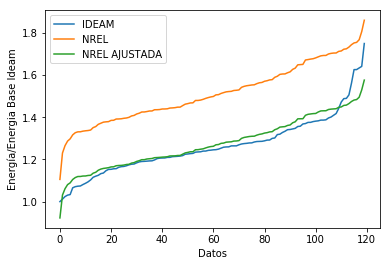

In [27]:
ejercicio('Medellin',[1,6],[2006,2006])

[2010, 2011, 2012, 2013, 2014, 2015]
[2010, 2011, 2012, 2013, 2014, 2015]
[2010, 2011, 2012, 2013, 2014, 2015]


,0,1
0,ENFICC real,4.160590
1,ENFICC satelital,4.632954
2,ENFICC satelital ajustada,4.677452
3,IDEAM-NREL AJUSTADA [RMSEn],0.124874
4,IDEAM-NREL AJUSTADA [MBE],0.047606
5,IDEAM-NREL AJUSTADA [P KSI],0.000462
6,IDEAM-NREL [RMSEn],0.107759
7,IDEAM-NREL [MBE],0.035764
8,IDEAM-NREL [P KSI],0.005967


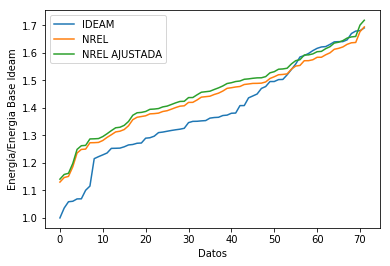

In [29]:
ejercicio('Barranquilla',[1,6],[2011,2011])

En el ejemplo anterior se puede observar todos los resultados necesarios, los valores de ENFICC para las tres series (real, satelital y ajustada), los errores entre la real y la ajustada, los errores entre la real y la satelital y por último la gráfica de los datos de promedio mensual de energía por hora para las tres series.

#### Nota: Como se ilustro en este ejemplo se realizó el procedimiento para todos los casos que se observaran en la parte 2 del informe. 

### Parte 2 Análisis bajo diferentes situaciones

En la primera parte el proposito 